In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import RMSprop
from keras.layers import LSTM, Dropout
from rbf_layer import RBFLayer, InitCentersRandom
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression

In [2]:
COMPANY = 'spl'

In [3]:
def roll_beta(window_size, stock, market):
    data = {'X': market, 'Y': stock}
    df = pd.DataFrame(data)
    cov = df.X.rolling(window=window_size).cov(df.Y)
    var = df.X.rolling(window=window_size).var()
    roling_beta = cov/var
    return np.array(roling_beta[window_size - 1:])

In [4]:
def return_from_stock(stock_data):
    stock = pd.read_csv(f"{stock_data}")
    #creating new column 'return' it is percentage change between current and last month close price
    stock['return'] = stock.Zamkniecie.pct_change()
    return np.array(stock['return'][1:]) # first value is NaN so [1:]

In [5]:
wig_20_return = return_from_stock('wig20_m.csv')
peo_return = return_from_stock('spl_m.csv')

In [6]:
peo_roll_beta = roll_beta(36, peo_return, wig_20_return)

In [7]:
peo_roll_beta

array([1.11865278, 1.1163534 , 1.14850904, 1.22687837, 1.23349178,
       1.23553373, 1.22292286, 1.25799717, 1.29315953, 1.36528026,
       1.4028063 , 1.40972053, 1.41384266, 1.407455  , 1.39485251,
       1.42484901, 1.43885703, 1.43887522, 1.4689987 , 1.43272604,
       1.49723403, 1.54504451, 1.5568105 , 1.58618558, 1.58943634,
       1.57311647, 1.62397654, 1.57556134, 1.61191498, 1.42758671,
       1.43962625, 1.4299944 , 1.47504536, 1.47110597, 1.38245353,
       1.33879023, 1.38356556, 1.39503193, 1.53786081, 1.54167398,
       1.54057218, 1.54698687, 1.54709556, 1.55836444, 1.53436323,
       1.50995908, 1.49392213, 1.48353869, 1.48414326, 1.49541824,
       1.41827128, 1.4102131 , 1.41980306, 1.41887142, 1.40341448,
       1.39724582, 1.35275901, 1.34995236, 1.3389582 , 1.32696104,
       1.32795784, 1.29002577, 1.2594931 , 1.27602482, 1.19612282,
       1.23446996, 1.20392546, 1.1847469 , 1.06826248, 0.99528033,
       1.09209669, 0.97719771, 0.94268158, 0.8672419 , 0.45997

In [8]:
# creating training dataset
df_data = pd.DataFrame({
    'target': peo_roll_beta,
    't-1': np.roll(peo_roll_beta, 1),
    't-2': np.roll(peo_roll_beta, 2),
    't-3': np.roll(peo_roll_beta, 3),
    't-4': np.roll(peo_roll_beta, 4),
    't-5': np.roll(peo_roll_beta, 5)
})


In [9]:
df_data = df_data.iloc[5:]
df_data

,target,t-1,t-2,t-3,t-4,t-5
5,1.235534,1.233492,1.226878,1.148509,1.116353,1.118653
6,1.222923,1.235534,1.233492,1.226878,1.148509,1.116353
7,1.257997,1.222923,1.235534,1.233492,1.226878,1.148509
8,1.293160,1.257997,1.222923,1.235534,1.233492,1.226878
9,1.365280,1.293160,1.257997,1.222923,1.235534,1.233492
...,...,...,...,...,...,...
200,1.265638,1.264277,1.278241,1.347568,1.269131,1.285957
201,1.288952,1.265638,1.264277,1.278241,1.347568,1.269131
202,1.181565,1.288952,1.265638,1.264277,1.278241,1.347568
203,1.271293,1.181565,1.288952,1.265638,1.264277,1.278241


In [10]:
X = df_data.iloc[:, -5:]
X

,t-1,t-2,t-3,t-4,t-5
5,1.233492,1.226878,1.148509,1.116353,1.118653
6,1.235534,1.233492,1.226878,1.148509,1.116353
7,1.222923,1.235534,1.233492,1.226878,1.148509
8,1.257997,1.222923,1.235534,1.233492,1.226878
9,1.293160,1.257997,1.222923,1.235534,1.233492
...,...,...,...,...,...
200,1.264277,1.278241,1.347568,1.269131,1.285957
201,1.265638,1.264277,1.278241,1.347568,1.269131
202,1.288952,1.265638,1.264277,1.278241,1.347568
203,1.181565,1.288952,1.265638,1.264277,1.278241


In [11]:
X = X[X.columns[::-1]]
X

,t-5,t-4,t-3,t-2,t-1
5,1.118653,1.116353,1.148509,1.226878,1.233492
6,1.116353,1.148509,1.226878,1.233492,1.235534
7,1.148509,1.226878,1.233492,1.235534,1.222923
8,1.226878,1.233492,1.235534,1.222923,1.257997
9,1.233492,1.235534,1.222923,1.257997,1.293160
...,...,...,...,...,...
200,1.285957,1.269131,1.347568,1.278241,1.264277
201,1.269131,1.347568,1.278241,1.264277,1.265638
202,1.347568,1.278241,1.264277,1.265638,1.288952
203,1.278241,1.264277,1.265638,1.288952,1.181565


In [12]:
y = df_data.target
y

5      1.235534
6      1.222923
7      1.257997
8      1.293160
9      1.365280
         ...   
200    1.265638
201    1.288952
202    1.181565
203    1.271293
204    1.285163
Name: target, Length: 200, dtype: float64

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0, shuffle=False)

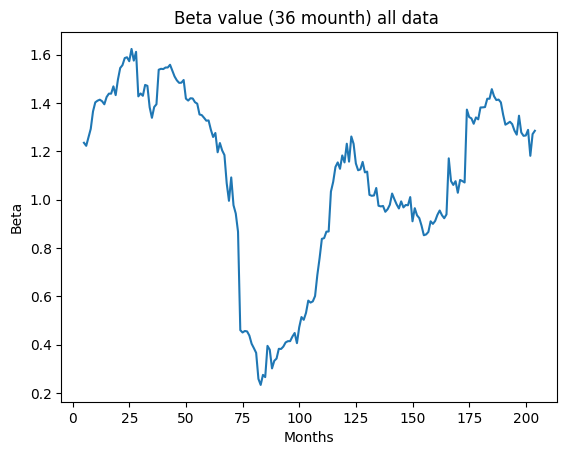

In [14]:
plt.plot(y)
plt.xlabel('Months')
plt.ylabel('Beta')
plt.title('Beta value (36 mounth) all data ')
plt.savefig(f'all_data{COMPANY}.png')

In [15]:
y_test

165    0.939037
166    1.171086
167    1.077010
168    1.061034
169    1.076507
170    1.028529
171    1.081728
172    1.077045
173    1.071185
174    1.372810
175    1.342061
176    1.336545
177    1.314163
178    1.340411
179    1.332481
180    1.381622
181    1.382008
182    1.383290
183    1.417797
184    1.417837
185    1.457505
186    1.428048
187    1.412354
188    1.414280
189    1.402700
190    1.351891
191    1.310424
192    1.315837
193    1.322471
194    1.312735
195    1.285957
196    1.269131
197    1.347568
198    1.278241
199    1.264277
200    1.265638
201    1.288952
202    1.181565
203    1.271293
204    1.285163
Name: target, dtype: float64

In [16]:
def single_plot(y_pred, y_real, title):
    x = np.arange(1, len(y_pred) + 1)
    plt.plot(x,y_real, label='real')
    plt.plot(x,y_pred, label='predicted')
    plt.xlabel('day')
    plt.ylabel('month')
    plt.legend()
    plt.title(title)
    return plt.plot()

In [17]:
def generate_plots(y_pred_train, y_pred_test, y_train, y_test, title_1, title_2, to_png, png_name):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))

    ax = axes[0]  # Wybór odpowiedniej osi
    plt.sca(ax)  # Ustawienie bieżącej osi
    single_plot(y_pred_train, y_train, title_1)

    ax = axes[1]  # Wybór odpowiedniej osi
    plt.sca(ax)  # Ustawienie bieżącej osi
    single_plot(y_pred_test, y_test, title_2)

    plt.tight_layout()
    if to_png:
        plt.savefig(f'{png_name}.png')
    plt.show()

## Bulding RBF network model

In [18]:
model = Sequential()
rbflayer = RBFLayer(10,
                    initializer=InitCentersRandom(X_train),
                    betas=2.0,
                    input_shape=(5,))
model.add(rbflayer)
model.add(Dense(1))

model.compile(loss='mean_squared_error',
              optimizer=RMSprop())


model.fit(X_train, y_train,
          batch_size=10,
          epochs=200,
          verbose=1)

Epoch 1/200
16/16 [==============================] - 1s 2ms/step - loss: 7.0536
Epoch 2/200
16/16 [==============================] - 0s 2ms/step - loss: 6.4211
Epoch 3/200
16/16 [==============================] - 0s 2ms/step - loss: 5.9194
Epoch 4/200
16/16 [==============================] - 0s 1ms/step - loss: 5.4454
Epoch 5/200
16/16 [==============================] - 0s 1ms/step - loss: 4.9883
Epoch 6/200
16/16 [==============================] - 0s 3ms/step - loss: 4.5597
Epoch 7/200
16/16 [==============================] - 0s 2ms/step - loss: 4.1544
Epoch 8/200
16/16 [==============================] - 0s 2ms/step - loss: 3.7672
Epoch 9/200
16/16 [==============================] - 0s 1ms/step - loss: 3.3979
Epoch 10/200
16/16 [==============================] - 0s 1ms/step - loss: 3.0441
Epoch 11/200
16/16 [==============================] - 0s 2ms/step - loss: 2.7206
Epoch 12/200
16/16 [==============================] - 0s 2ms/step - loss: 2.4170
Epoch 13/200
16/16 [=================

2/2 [==============================] - 0s 16ms/step


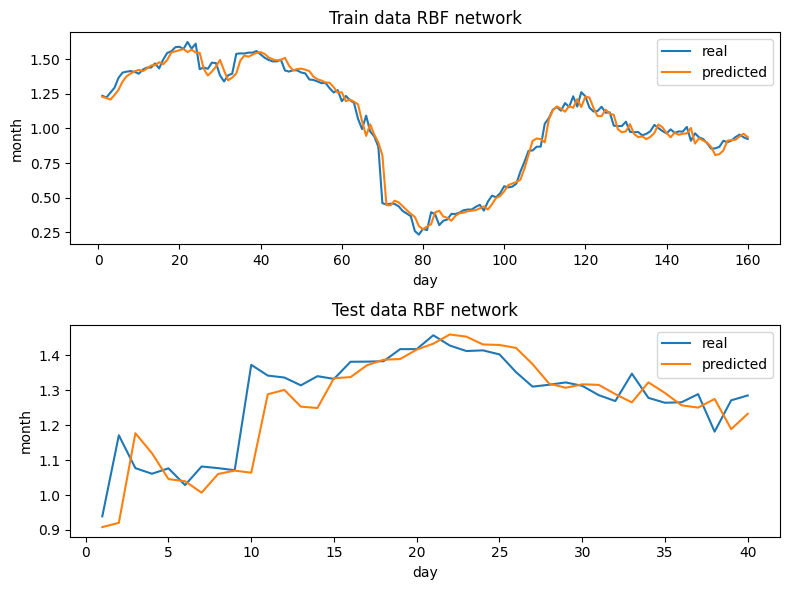

In [19]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
generate_plots(y_pred_train, y_pred_test, y_train, y_test, 'Train data RBF network', 'Test data RBF network', True, f'RBF_{COMPANY}')

In [20]:
import matplotlib.pyplot as plt

def score_table(y_train, y_pred_train, y_test, y_pred_test, title):
    mse_train = mean_squared_error(y_train, y_pred_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    r2_train = r2_score(y_train, y_pred_train)

    mse_test = mean_squared_error(y_test, y_pred_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    r2_test = r2_score(y_test, y_pred_test)
    # Tworzenie tabeli
    data = {'data': ['train', 'test'],
            'MSE': [round(mse_train, 3), round(mse_test, 3)],
            'MAE': [round(mae_train, 3), round(mae_test, 3)],
            'R^2': [round(r2_train, 3), round(r2_test, 3)]
            }

    df = pd.DataFrame(data)

    # Tworzenie wykresu tabeli
    fig, ax = plt.subplots()  # Ustalenie rozmiaru wykresu
    ax.axis('off')  # Wyłączenie osi

    table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
    # Zapisywanie tabeli jako obraz PNG
    plt.savefig(f'tabela{title}.png', bbox_inches='tight', pad_inches=0.5)
    plt.show()

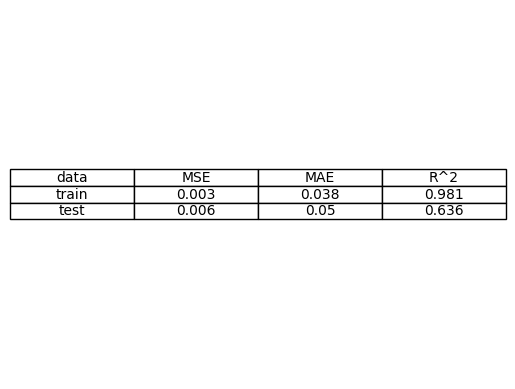

In [21]:
score_table(y_train, y_pred_train, y_test, y_pred_test, f'RBF_{COMPANY}')

## Bulding XGBRegressor model

In [29]:
from xgboost import XGBRegressor
my_model = XGBRegressor(n_estimators=1000)
my_model.fit(X_train, y_train, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

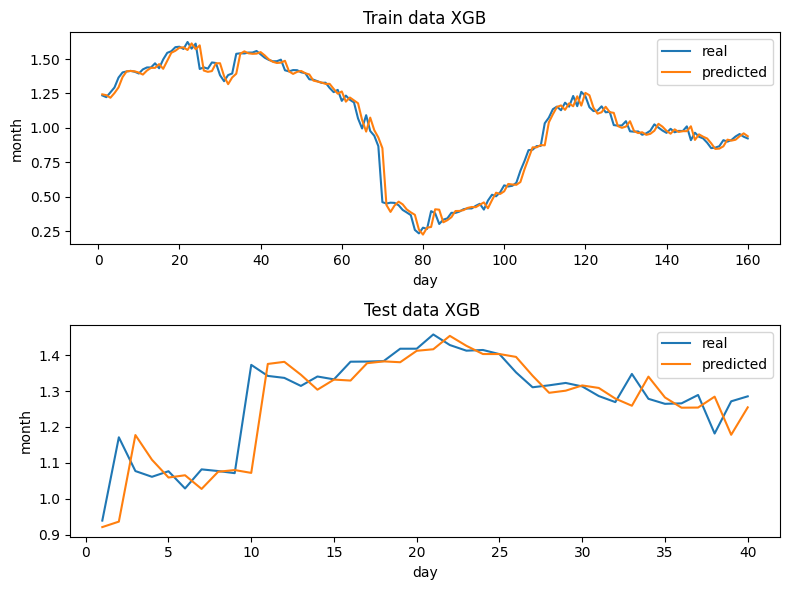

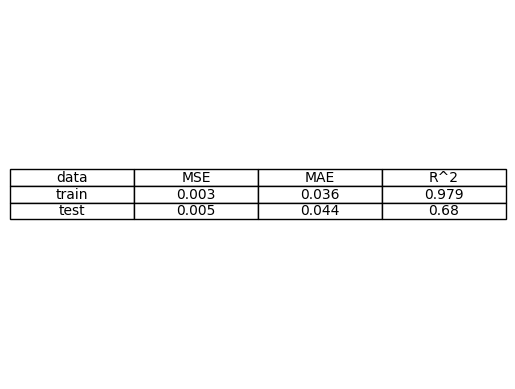

In [30]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
generate_plots(y_pred_train, y_pred_test, y_train, y_test, 'Train data XGB', 'Test data XGB ', True, f'XGB_{COMPANY}')
score_table(y_train, y_pred_train, y_test, y_pred_test, f'XGB_table_{COMPANY}')

## Bulding LSTM network

In [24]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 100)            40800     
                                                                 
 dropout (Dropout)           (None, 5, 100)            0         
                                                                 
 lstm_1 (LSTM)               (None, 5, 100)            80400     
                                                                 
 dropout_1 (Dropout)         (None, 5, 100)            0         
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dense_1 (Dense)             (None, 25)                2525      
                                                                 
 dense_2 (Dense)             (None, 1)                

In [25]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size= 1, epochs=20)

Epoch 1/20
160/160 [==============================] - 5s 5ms/step - loss: 0.0937
Epoch 2/20
160/160 [==============================] - 1s 6ms/step - loss: 0.0308
Epoch 3/20
160/160 [==============================] - 1s 6ms/step - loss: 0.0211
Epoch 4/20
160/160 [==============================] - 1s 6ms/step - loss: 0.0197
Epoch 5/20
160/160 [==============================] - 1s 6ms/step - loss: 0.0193
Epoch 6/20
160/160 [==============================] - 1s 6ms/step - loss: 0.0228
Epoch 7/20
160/160 [==============================] - 1s 6ms/step - loss: 0.0176
Epoch 8/20
160/160 [==============================] - 1s 6ms/step - loss: 0.0174
Epoch 9/20
160/160 [==============================] - 1s 6ms/step - loss: 0.0168
Epoch 10/20
160/160 [==============================] - 1s 6ms/step - loss: 0.0162
Epoch 11/20
160/160 [==============================] - 1s 6ms/step - loss: 0.0162
Epoch 12/20
160/160 [==============================] - 1s 6ms/step - loss: 0.0134
Epoch 13/20
160/160 [====

2/2 [==============================] - 1s 0s/step


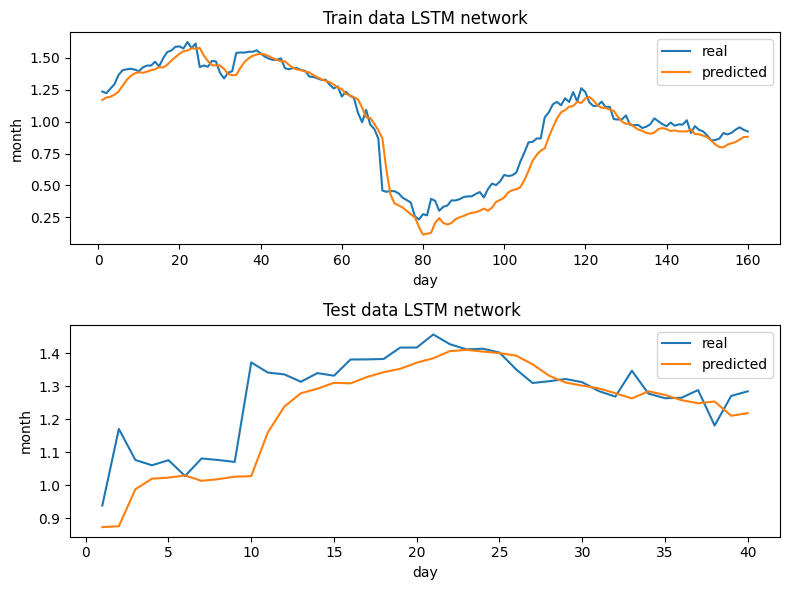

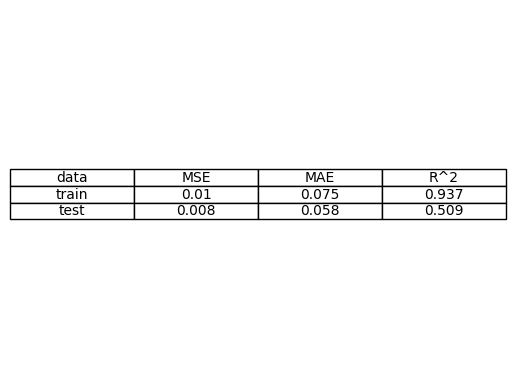

In [26]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
generate_plots(y_pred_train, y_pred_test, y_train, y_test, 'Train data LSTM network', 'Test data LSTM network ', True, f'LSTM_{COMPANY}')
score_table(y_train, y_pred_train, y_test, y_pred_test, f'LSTM_table_{COMPANY}')

## Bulding Linear regression model

In [27]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

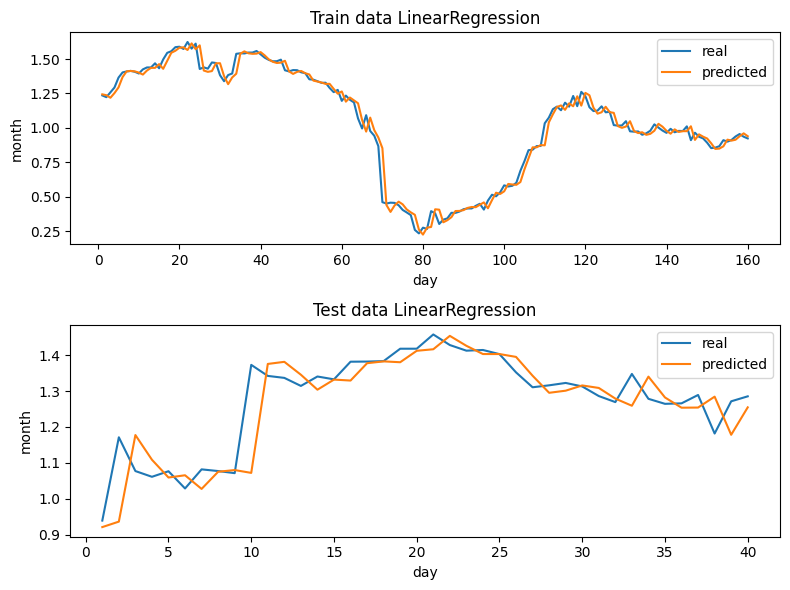

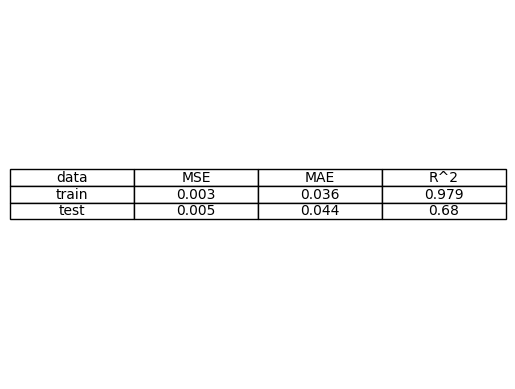

In [28]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
generate_plots(y_pred_train, y_pred_test, y_train, y_test, 'Train data LinearRegression', 'Test data LinearRegression', True, f'LinearRegression_{COMPANY}')
score_table(y_train, y_pred_train, y_test, y_pred_test, f'LinearRegression_{COMPANY}')